In [1]:
from datetime import datetime
from matplotlib import pyplot as plt
from math import sqrt
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
import tensorflow as tf
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Task 1

In [2]:
# Read in dataset 1
data = pd.read_excel("dataset_1.xls")

## Data Cleaning

From the initial viewing of the data, we noticed that many instances had missing data for some dates (usually tdate10 through tdate12). For now, we have set those values to NaN. For the non-date values, we imputed values as the column's average.

We also noticed whitespace occurred in the columns. We erased them and lowercased the names for simplicity.

In [3]:
# Example of an instance without data for each date, shows column formatting as well
data.iloc[1,:]

State                          11
 Herd                           2
# PTAs                        319
 PTAM                         309
PTAF                           23
PTAP                           12
RHA # cows                    331
 % W PTAs                      97
 RHAM                       30020
 RHAF                        1134
 RHAP                         923
Tdate1        2018-08-27 00:00:00
 Milk1                         85
 Fat1                         3.6
 Pro1                           3
Tdate2        2018-07-17 00:00:00
 Milk2                         80
 Fat2                         3.7
 Pro2                         2.9
Tdate3        2018-06-14 00:00:00
 Milk3                         87
 Fat3                         3.7
 Pro3                         3.1
Tdate4        2018-05-15 00:00:00
 Milk4                         80
 Fat4                         3.9
 Pro4                         3.1
Tdate5        2018-03-22 00:00:00
 Milk5                         81
 Fat5         

In [4]:
# Remove whitespace from column names
data.columns = list(map(lambda x: x.strip().lower(), data.columns))

# Find values of '  .' and set to NaN, or impute mean
for col in data.columns:
    try:
        data[col][data[col] == '  .'] = np.nan
        data[col][data[col] == ' . '] = np.nan
        data[col][data[col].apply(lambda x: x == '    .')] = \
            (data[col][data[col].apply(lambda x: x != '    .')]).mean()
        if "date" not in col:
            data[col] = data[col].astype(float)
    except:
        continue

# Remove rows with missing rhap and rhaf values
data = data[~data.rhap.apply(lambda x: x == '   .')]
data = data[~data.rhaf.apply(lambda x: x == '   .')]

## Data Analysis

In [5]:
# Dimensions of data
data.shape

(7868, 59)

In [6]:
# Initial summary statistics
data.describe()

,state,herd,# ptas,ptam,ptaf,ptap,rha # cows,% w ptas,rham,milk1,...,pro9,milk10,fat10,pro10,milk11,fat11,pro11,milk12,fat12,pro12
count,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,...,6377.000000,5862.000000,5862.000000,5862.000000,5084.000000,5084.000000,5084.000000,3792.000000,3792.000000,3792.000000
mean,31.645018,3948.971022,142.494026,151.996187,9.072572,5.805923,214.635613,62.069268,22967.245933,61.246441,...,3.150902,62.032071,3.875384,3.140873,61.739772,3.805566,3.096755,62.259757,3.779562,3.064030
std,11.873456,2279.585578,355.704442,354.728682,12.943216,10.895686,440.014365,28.295911,4037.126645,12.274327,...,0.134823,11.677153,0.320749,0.137300,11.787988,0.313746,0.127782,11.521145,0.301008,0.122117
min,11.000000,1.000000,1.000000,-2940.000000,-108.000000,-99.000000,2.000000,0.000000,462.000000,2.000000,...,2.500000,15.000000,2.200000,2.500000,17.000000,2.400000,2.500000,15.000000,2.400000,2.500000
25%,23.000000,1976.750000,31.000000,-1.000000,3.000000,1.000000,60.000000,45.000000,20598.000000,54.000000,...,3.100000,55.000000,3.700000,3.100000,54.000000,3.600000,3.000000,55.000000,3.600000,3.000000
50%,31.000000,3947.500000,58.000000,213.000000,11.000000,7.000000,94.000000,71.000000,23328.000000,62.000000,...,3.100000,63.000000,3.900000,3.100000,62.000000,3.800000,3.100000,63.000000,3.800000,3.100000
75%,41.000000,5921.250000,117.000000,371.000000,17.000000,12.000000,186.000000,84.000000,25661.000000,70.000000,...,3.200000,70.000000,4.100000,3.200000,70.000000,4.000000,3.200000,70.000000,3.900000,3.100000
max,74.000000,7919.000000,9789.000000,1234.000000,63.000000,44.000000,9008.000000,250.000000,36275.000000,129.000000,...,3.700000,100.000000,6.600000,3.800000,102.000000,6.200000,3.700000,100.000000,5.900000,3.700000


In [7]:
# Amount of unique states the herds are from
len(data.state.unique())

38

In [8]:
# Amount of unique herds, since each row is a unique herd, should be the same amount - removed rows
len(data.herd.unique())

7868

Each herd had 6-12 observations of herd production taken at various dates in the past year. In evaluating these entries, we noticed several herds had very little variation in their total milk production over the year.

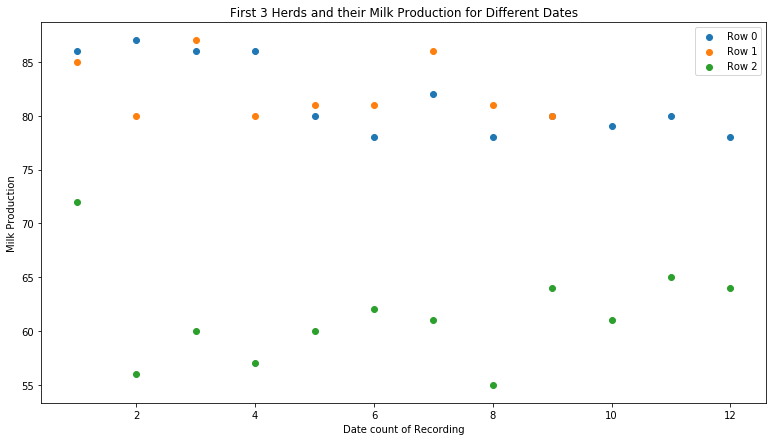

In [9]:
cowMilkList = [col for col in data if col.startswith('milk')]
cowMilk = data[cowMilkList]
plt.figure(figsize=(13,7))
for i in range(3):
    plt.scatter(range(1,13),cowMilk.iloc[i])
plt.xlabel("Date count of Recording")
plt.ylabel("Milk Production")
plt.title("First 3 Herds and their Milk Production for Different Dates")
plt.legend(["Row 0", "Row 1", "Row 2"]);

We wanted to investigate if the difference in production month-to-month was worth looking into, so for each output variable of milk, fat, and protein, we found the standard deviation of that variable for each herd individually, then took the average of the standard deviations for each output.

In [10]:
cowFatList = [col for col in data if col.startswith('fat')]
cowProList = [col for col in data if col.startswith('pro')]
cowMilkList = [col for col in data if col.startswith('milk')]

cowFat = data[cowFatList]
cowPro = data[cowProList]
cowMilk = data[cowMilkList]

sds = 0
count = 0
for lst in [cowFat,cowPro,cowMilk]:
    for i in range(lst.shape[0]):
        x = pd.Series(lst.iloc[[i]].values.tolist()[0]).describe()[2]
        add = 0 if np.isnan(x) else 1
        x = 0 if np.isnan(x) else x
        count += add
        sds += x
    print(sds/count)

0.21460056115809667
0.16108592713282582
1.7480361062898773


As we can see, the average standard deviation of each output variable was very low, especially in comparison to the actual raw values we see, so we decided that the month-to-moth difference in production was insignificant enough to be ignored, and as such could just take each herd's average as our expected output variable

## Lasso Regression Model Creation and Data Setup

### Prepare training and test data

In [11]:
# Create functions for automation between subjects

def prepare_data(data, subject):
    subject_columns = []
    
    # For each column, test if the column pertains to the subject
    for col in data.columns:
        if subject in col:
            subject_columns.append(col)

    # Return the average along the row of all of the subject columns
    return data.loc[:, subject_columns].mean(axis=1, skipna=True)

def split_data(X, y, test_size=0.3):
    
    # Remove rows where the truth label is NA
    X_temp = X[~y.isna()]
    y_temp = y[~y.isna()]
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

In [12]:
# Prepare relevant columns
subjects = ["milk", "fat", "pro"]
feature_cols = ['# ptas', 'ptam', 'ptaf', 'ptap', 'rha # cows',
                '% w ptas', 'rham', 'rhaf', 'rhap']

# Dictionaries for each subject
y = {}
subject_splits = {}
cv_scores = {}
test_rr = {}
adjusted_r2 = {}
subject_coef = {}
subject_preds = {}

# Training feature vectors
X = data.loc[:, feature_cols]

# Normalize feature vectors
X = X.apply(lambda x: (x - x.mean()) / x.std())

# Split data into train and test for each subject
for subject in subjects:
    y[subject] = prepare_data(data, subject)
    subject_splits[subject] = split_data(X, y[subject])

### Perform cross-validation to test values of alpha

In [13]:
for subject in subjects:
    # Keep track of cv scores for the current subject
    temp_scores = {}
    
    # For each alpha value, perform cross validation w/ Lasso and keep track of scores
    for a in range(0, 25):
        X_train, _, y_train, _ = subject_splits[subject]
        lasso = Lasso(alpha=a)
        temp_scores[a] = cross_val_score(lasso, X_train, y_train, cv=10).mean()
        
    # Store all scores in dictionary
    cv_scores[subject] = temp_scores

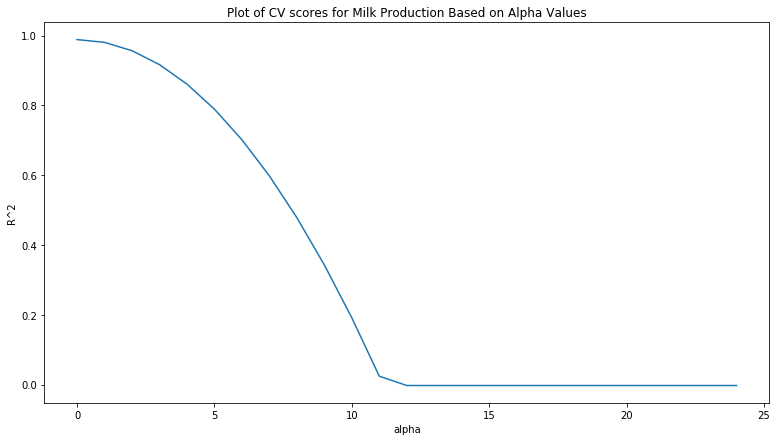

In [14]:
plt.figure(figsize=(13,7))
plt.plot(cv_scores["milk"].keys(), cv_scores["milk"].values())
plt.title("Plot of CV scores for Milk Production Based on Alpha Values")
plt.xlabel("alpha")
plt.ylabel("R^2");

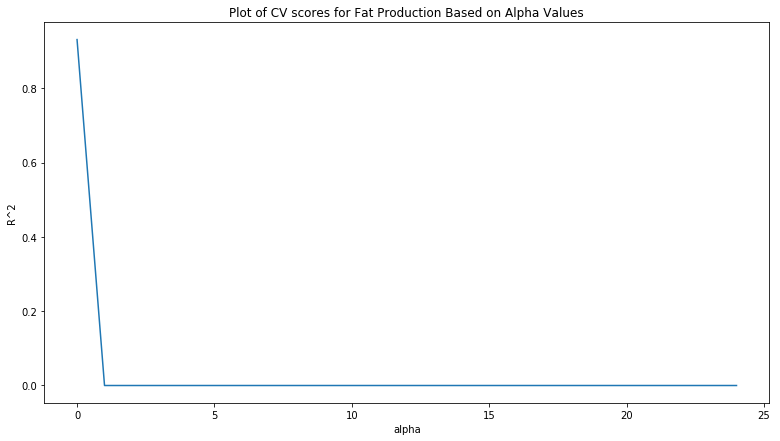

In [15]:
plt.figure(figsize=(13,7))
plt.plot(cv_scores["fat"].keys(), cv_scores["fat"].values())
plt.title("Plot of CV scores for Fat Production Based on Alpha Values")
plt.xlabel("alpha")
plt.ylabel("R^2");

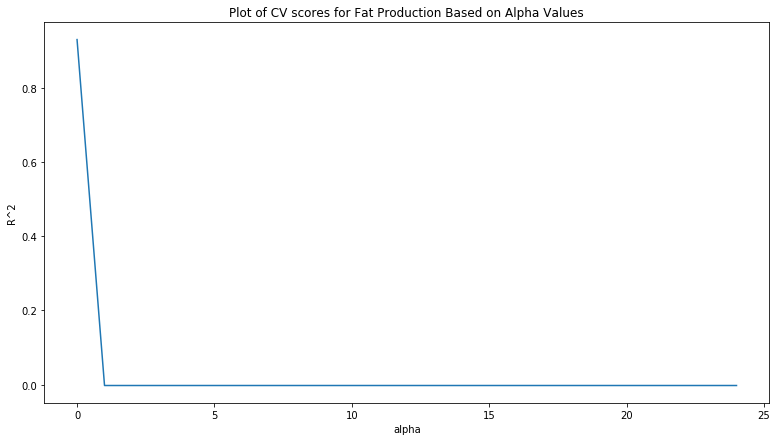

In [16]:
plt.figure(figsize=(13,7))
plt.plot(cv_scores["pro"].keys(), cv_scores["pro"].values())
plt.title("Plot of CV scores for Fat Production Based on Alpha Values")
plt.xlabel("alpha")
plt.ylabel("R^2");

As you can see, variations in alpha don't cause much difference in R^2 values for milk. For fat and protein, as alpha increase, our training accuracy decreases significantly. This is due to the over-complexity of the models for those large regularization values. Therefore, we will elect to have a less complex model with alpha = 0 (no regularization).

### Evaluate on test data

In [17]:
# For each subject, fit on train and predict on test
for subject in subjects:
    lasso = Lasso(alpha=0)
    X_train, X_test, y_train, y_test = subject_splits[subject]
    lasso.fit(X_train, y_train)
    subject_preds[subject] = lasso.predict(X_test)
    
    # Store R^2 values in dictionary
    test_rr[subject] = lasso.score(X_test, y_test)
    adjusted_r2[subject] = (1 - (1 - test_rr[subject]) *
                          ((len(X_train) - 1) / (len(X_train) - len(feature_cols) - 1)))
    
    # Store coeficients in dictionary
    subject_coef[subject] = lasso.coef_

adjusted_r2

{'milk': 0.9856085934327625,
 'fat': 0.950292652761937,
 'pro': 0.9390109261707482}

Test evaluation metrics seem really good. But we are still skeptical of the results. In future work, we will analyze the feature importances to determine what is playing the biggest role in the predictions.

# Task 2

### Analysis of Features for Feature Engineering/Selection

In [18]:
for subject in subjects:
    print("\n###### %s correlations ######\n" % subject)
    for feature in feature_cols:
        print(feature + ": ", pearsonr(subject_splits[subject][0][feature], subject_splits[subject][2])[0])


###### milk correlations ######

# ptas:  0.26995172141944174
ptam:  0.4308178673749354
ptaf:  0.4427066137232595
ptap:  0.44095566137781533
rha # cows:  0.2605818921039631
% w ptas:  0.3116796059924592
rham:  0.9942478564501585
rhaf:  0.9223071652390052
rhap:  0.9760266473087724

###### fat correlations ######

# ptas:  -0.031191479918729573
ptam:  -0.06951235074102281
ptaf:  0.032909989432143245
ptap:  -0.015908594146170373
rha # cows:  -0.049391666529500285
% w ptas:  -0.005700672534776266
rham:  -0.13201058837469967
rhaf:  0.23653850053048373
rhap:  -0.06800282438054155

###### pro correlations ######

# ptas:  -0.008504507786087608
ptam:  -0.0420378189966291
ptaf:  0.04874437046776652
ptap:  0.03629667400506456
rha # cows:  -0.009870631711360723
% w ptas:  0.0033862242237734197
rham:  -0.10284227906694336
rhaf:  0.024540212532428315
rhap:  0.08899126049196585


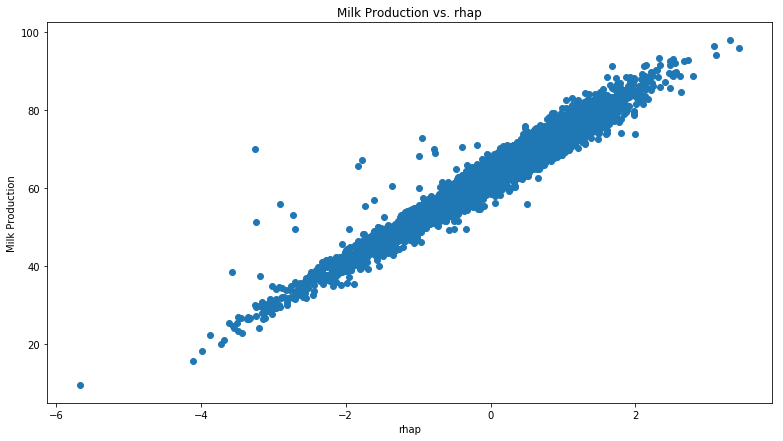

In [19]:
plt.figure(figsize=(13,7))
plt.scatter(subject_splits["milk"][0]["rhap"], subject_splits["milk"][2])
plt.title("Milk Production vs. rhap")
plt.xlabel("rhap")
plt.ylabel("Milk Production");

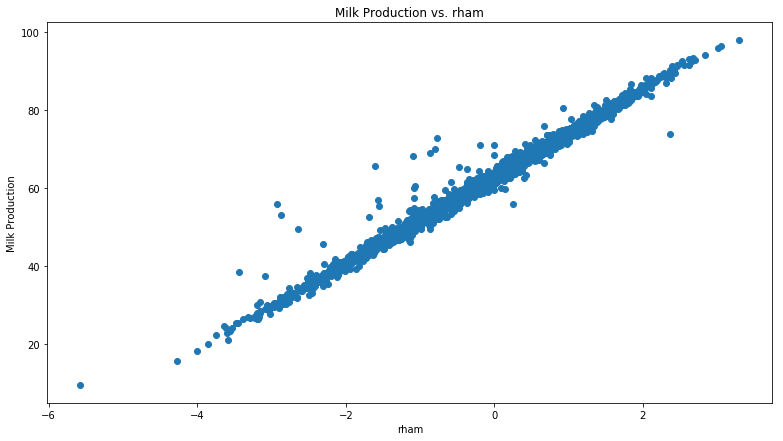

In [20]:
plt.figure(figsize=(13,7))
plt.scatter(subject_splits["milk"][0]["rham"], subject_splits["milk"][2])
plt.title("Milk Production vs. rham")
plt.xlabel("rham")
plt.ylabel("Milk Production");

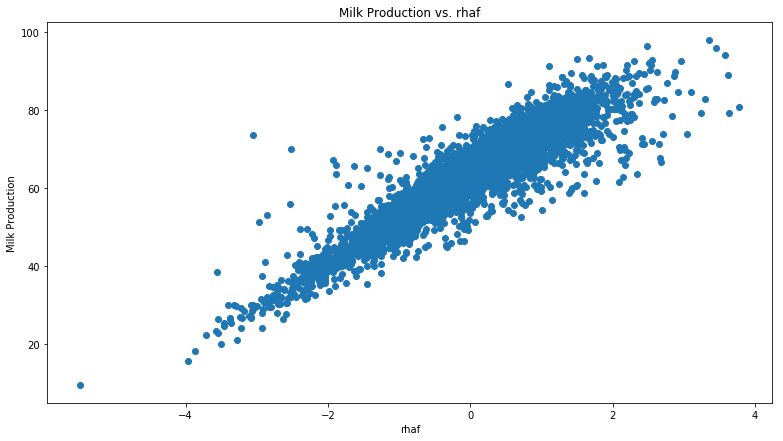

In [21]:
plt.figure(figsize=(13,7))
plt.scatter(subject_splits["milk"][0]["rhaf"], subject_splits["milk"][2])
plt.title("Milk Production vs. rhaf")
plt.xlabel("rhaf")
plt.ylabel("Milk Production");

We can confirm that the rhaf, rhap, and rham columns have great correlations close to values of 1 to milk production. However, for protein and fat production, none of the columns play much of a role. From our lasso regression model, we can assume that the combination of features with the learned weight vectors play a critical role in predictions, hence the high adjusted R^2 values.

For our milk production model, we can now attempt to reduce the complexity of our model by reducing the dimensional space to the 3 columns. This not only gives us a simpler model, but it also has the potential to reduce training and prediction speed. Now that we know there are only 3 features to account for this model, we can even reduce tree depths of our future random forest model.

### Lasso Regression with Feature Engineering

In [22]:
t_cols = ["rhaf", "rhap", "rham"]

lasso = Lasso(alpha=0)
X_train, X_test, y_train, y_test = subject_splits["milk"]
lasso.fit(X_train.loc[:, t_cols], y_train)

r2 = lasso.score(X_test.loc[:, t_cols], y_test)
adj_r2 = (1 - (1 - r2) * ((len(X_train) - 1) / (len(X_train) - len(feature_cols) - 1)))
adj_r2

0.9856299083088231

The new adjusted R^2 value for milk production is pretty much identical to the old. This could actually be explained by the fact that Lasso Regression is very good at getting weight vector values of 0 or close to 0, reducing the impact of features with low dependency. The feature engineering is still a benefit, as we have mentioned previously, since it makes our models less complex and has potential of increasing speed for models down the line.

### Random Forest Creation

In [23]:
# Model with all features for Milk Production

# Start timer
time_start = datetime.now()

test_rr_rf = {}
for subject in subjects:
    randomf = RandomForestRegressor(n_estimators = 1000)
    X_train, X_test, y_train, y_test = subject_splits[subject]
    randomf.fit(X_train,y_train)
    test_rr_rf[subject] = randomf.score(X_test,y_test)
    
# End timer
time_end = datetime.now()

print(test_rr_rf)

# Execution time
print(time_end - time_start)

{'milk': 0.9838399169487315, 'fat': 0.9201287566573417, 'pro': 0.8180807672339141}
0:01:27.272452


In [24]:
# Model with only 3 features for Milk Production

# Start timer
time_start = datetime.now()

# for each subject, fit on train and predict on test
### for milk, only use RHAP, RHAM, and RHAF since those have the strongest correlation with the real results
test_rr_rf = {}
for subject in subjects:
    randomf = RandomForestRegressor(n_estimators = 1000)
    X_train, X_test, y_train, y_test = subject_splits[subject]
    if subject == "milk":
        X_train = X_train[["rham","rhaf","rhap"]]
        X_test = X_test[["rham","rhaf","rhap"]]
    randomf.fit(X_train,y_train)
    test_rr_rf[subject] = randomf.score(X_test,y_test)
    
# End timer
time_end = datetime.now()

print(test_rr_rf)

# Execution time
print(time_end - time_start)

{'milk': 0.9828744527185692, 'fat': 0.9199798075781531, 'pro': 0.8066545542310244}
0:01:10.771443


The Random Forest model also has high R^2 metrics, but not as high as Lasso's. Also, the execution time of the training and testing of the model was much longer than our Lasso Regression model. Random Forest takes over 1 minute to execute for all 3 models while Lasso finishes in a matter of seconds. In real-world prediction and training, fast execution time is much more preferrable, which would lead us to choose solely the Lasso model since it has both the better metric results, and much faster execution time.

As you can see, using only 3 features for the Random Forest model impacted the execution time by a difference of 17 seconds. On scale, this could play a huge role in real-time training and prediction.

### Neural Network Creation

Due to the success of our ridge regression and random forest model, we have decided to forego the creation of our neural network. We simply thought that there is no point in creating a much more complex model if our more simple regression and random forest models perform well. If in the future, we decide to complete the creation of our neural network, we would include it for boosting of all of our models.

We have kept the code set-up for our neural network here in case we decide to use it.

In [25]:
"""
d = len(feature_cols)

# Hyper-parameters
HIDDEN_NUM = 15
OUTPUT_NUM = 2
INPUT_NUM = X_train.shape[0]
EPOCHS = 500
LEARNING_RATE = 0.0005
TRAIN_STEPS = 100
BATCH_SIZE = 169

x_train = tf.placeholder(tf.float32, [1, d])
y_train = tf.placeholder(tf.float32, [1, d])

weights = {"hidden": tf.Variable(tf.zeros[d, 1]),
           "output": tf.Variable(tf.zeros[d, 1])}
biases = {"hidden": tf.Variable(tf.zeros[1]),
          "output": tf.Variable(tf.zeros[1])}

hidden_layer = tf.nn.relu(tf.add(tf.matmul(x_train, weights["hidden"]), biases["hidden"]))
output_layer = tf.add(tf.matmul(hidden_layer, weights["output"]), biases["output"])

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train, logits=output_layer))
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

correct_prediction = tf.equal(tf.argmax(output_layer,1), tf.argmax(y_train,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

prediction = tf.argmax(output_layer,1)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    test_labels = sess.run(test_labels)
    loss_total = 0
    acc_total = 0
    for i in range(EPOCHS):
        start_index = 0
        for j in range(TRAIN_STEPS):
            x_batch, y_batch = next_batch(train_data, feature_cols, "milk", start_index, BATCH_SIZE)
            x_batch = np.asarray(x_batch.postText.tolist())
            y_batch = tf.one_hot(np.array(y_batch), 2)
            y_batch = sess.run(y_batch)
            start_index += BATCH_SIZE
            sess.run([optimizer], feed_dict = {x_train: x_batch, y_train: y_batch})
"""

'\nd = len(feature_cols)\n\n# Hyper-parameters\nHIDDEN_NUM = 15\nOUTPUT_NUM = 2\nINPUT_NUM = X_train.shape[0]\nEPOCHS = 500\nLEARNING_RATE = 0.0005\nTRAIN_STEPS = 100\nBATCH_SIZE = 169\n\nx_train = tf.placeholder(tf.float32, [1, d])\ny_train = tf.placeholder(tf.float32, [1, d])\n\nweights = {"hidden": tf.Variable(tf.zeros[d, 1]),\n           "output": tf.Variable(tf.zeros[d, 1])}\nbiases = {"hidden": tf.Variable(tf.zeros[1]),\n          "output": tf.Variable(tf.zeros[1])}\n\nhidden_layer = tf.nn.relu(tf.add(tf.matmul(x_train, weights["hidden"]), biases["hidden"]))\noutput_layer = tf.add(tf.matmul(hidden_layer, weights["output"]), biases["output"])\n\nloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train, logits=output_layer))\noptimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)\n\ncorrect_prediction = tf.equal(tf.argmax(output_layer,1), tf.argmax(y_train,1))\naccuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))\n\nprediction 

# Task 3

We previously had running a grid-search for hyper-parameter optimization of our models, but since we have finalized with using just the Lasso model, this won't be necessary. We had previously tuned our regularization parameter in task 1 when we tested different values of alpha during cross-validation. We had concluded that regularization actually wasn't helping training accuracy, so we had decided to keep alpha at 0, which actually makes the model an Ordinary Least Squares model.

This task will now just focus on finalizing our metrics and displaying our results.

### Finalize Evaluation Metrics

In [44]:
subject_rmse = {}
for subject in subjects:
    preds = subject_preds[subject]
    _, _, _, actual = subject_splits[subject]
    subject_rmse[subject] = sqrt(mean_squared_error(actual, preds))

print(subject_rmse)

{'milk': 1.3159421823515656, 'fat': 0.06158469815338443, 'pro': 0.030219184266439953}


Root mean squared error is incredibly small for each of the three targets. We chose to include RMSE as one of our metrics because it is a great general purpose metric for showing how different predicted values are from actual values. It also increases error the higher the difference is in the results. This is important because it would alert us if some of our results are very off. Below we will plot the predictions and truth values for 100 samples for each model to see how different the values are.

### Plots of Predictions and Truth Values

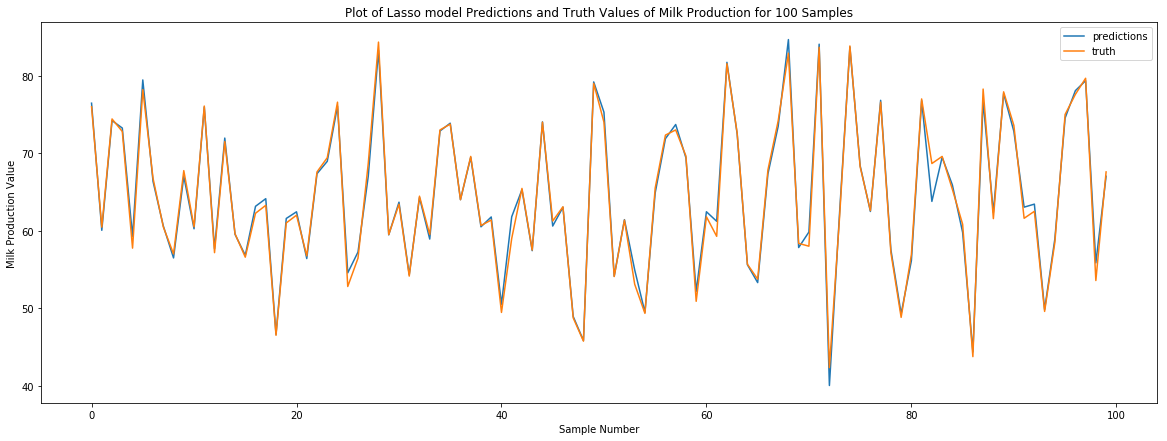

In [52]:
preds = subject_preds["milk"]
_, _, _, actual = subject_splits["milk"]

plt.figure(figsize=(20,7))
plt.plot(range(100), subject_preds["milk"][:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of Lasso model Predictions and Truth Values of Milk Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Milk Production Value");

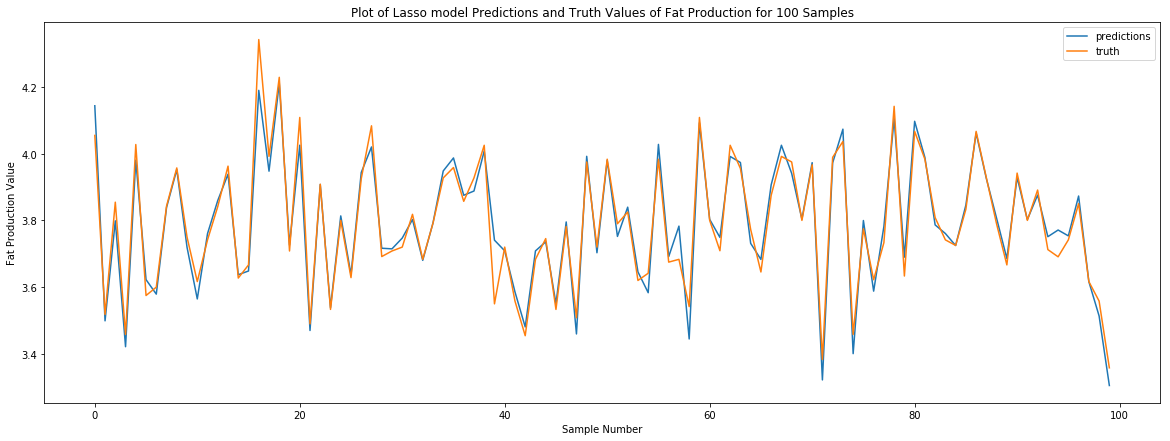

In [51]:
preds = subject_preds["fat"]
_, _, _, actual = subject_splits["fat"]

plt.figure(figsize=(20,7))
plt.plot(range(100), preds[:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of Lasso model Predictions and Truth Values of Fat Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Fat Production Value");

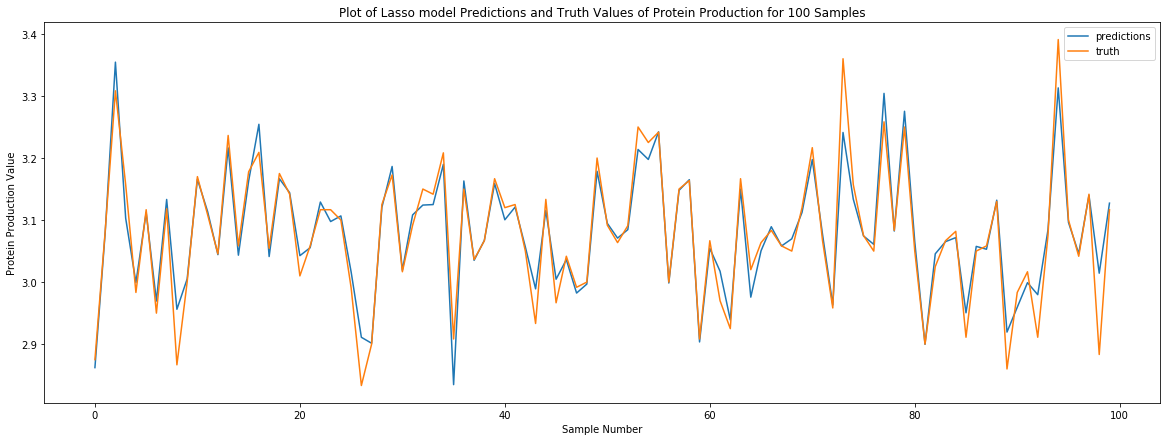

In [50]:
preds = subject_preds["pro"]
_, _, _, actual = subject_splits["pro"]

plt.figure(figsize=(20,7))
plt.plot(range(100), preds[:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of Lasso model Predictions and Truth Values of Protein Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Protein Production Value");

As you can see, predicted values are very similar to the truth values for the test set for each target variable. This confirms our evaluation metrics of R^2 and RMSE.